In [1]:
%pip install kaggle pandas numpy matplotlib seaborn scikit-learn tensorflow tensorflow-macos tensorflow-metal


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [35]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


TensorFlow version: 2.16.2
Num GPUs Available:  1


### Project Description
#### CNN Cancer Detection Kaggle Mini-Project

##### Step 1: Brief description of the problem and data
Our goal is to try to accurately identify metastatic cancer in small image patches taken from larger digital pathology scans.  This is a binary clasification problem, which we will attempt to use Convolutional Neural Networks to solve.

We are using the histopathologic-cancer-detection database from Kaggle.  It has approximately 277k individual images, split into test and validation groups, with a train_labels file which indicates 0 for benign and 1 which indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.  Duplicates have been removed.  (Source: Kaggle)

We will import that dataset below:

In [3]:
# Download the dataset

# Uncomment if re-download is needed
!kaggle competitions download -c histopathologic-cancer-detection

# with zipfile.ZipFile('histopathologic-cancer-detection.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

Traceback (most recent call last):
  File "/Users/mark/.pyenv/versions/3.10.13/bin/kaggle", line 33, in <module>
    sys.exit(load_entry_point('kaggle==1.6.14', 'console_scripts', 'kaggle')())
  File "/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 1026, in competition_download_cli
    self.competition_download_files(competition, path, force,
  File "/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 989, in competition_download_files
    url = response.retries.history[0].redirect_location.split('?')[0]
IndexError: tuple index out of range


label
0    130908
1     89117
Name: count, dtype: int64


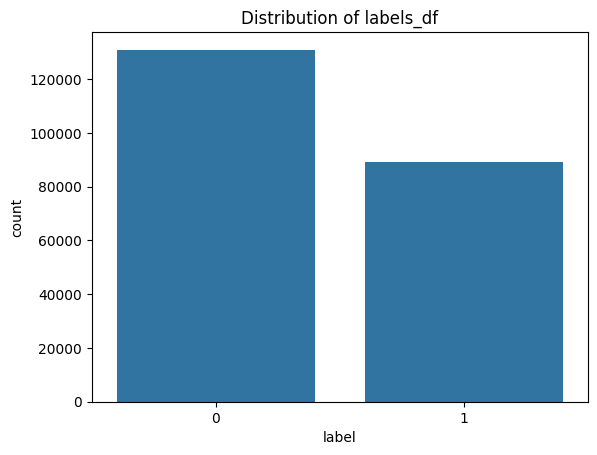

Image ID: d13b8774ce6b470659443e1c14b0c40328752ca8 - Size: (96, 96) - Mode: RGB
Image ID: d13b8774ce6b470659443e1c14b0c40328752ca8 - Min Pixel Value: 13 - Max Pixel Value: 255
Example pixel value: $[246 178 235]


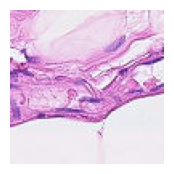

Missing values:
 id       0
label    0
dtype: int64
Duplicate values: 0
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [4]:
# Part 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

# Inspect labels
labels_df = pd.read_csv('data/train_labels.csv')
print(labels_df['label'].value_counts())

# What is the distribution of positive/negative cases?
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of labels_df')
plt.show()

# What does an image look like?
example_image_id = labels_df['id'].sample(1).values[0]

plt.figure(figsize=(2, 2))
image_path = os.path.join('data/train', f'{example_image_id}.tif')
image = Image.open(image_path)
label = labels_df[labels_df['id'] == example_image_id]['label'].values[0]
image_array = np.array(image)
print(f"Image ID: {example_image_id} - Size: {image.size} - Mode: {image.mode}")
print(f"Image ID: {example_image_id} - Min Pixel Value: {image_array.min()} - Max Pixel Value: {image_array.max()}")
print(f"Example pixel value: ${image_array[0][0]}")
plt.imshow(image)
plt.axis('off')
plt.show()



# Are there any missing values?
missing_values = labels_df.isnull().sum()
print('Missing values:\n', missing_values)

# Are there any duplicates?
duplicate_values = labels_df.duplicated().sum()
print('Duplicate values:', duplicate_values)

# Preview labels_df
print(labels_df.head())

#### Data analysis

- The data is already very clean, and simple, as described by the kaggle summary.  
- There are no duplicates, and no missing values.
- There are a little over 120,000 negative cases, and 90,000 negative cases
- The images are 96x96 pixels with values of 0-255

##### Step 3: Model Architecture

Convolutional Neural Networks (CNN), are a popular choice for image detection/classification tasks.  Filters/kernals can be used to detect shapes and edges, which will be our approach for detecting malignant cells in the image data set.

Some popular architecures include:
- VGGNet: Simple to understand, but a little computationally inefficient
- InceptionNet: Little more complicated
- ResNet: Uses skip connections

In [5]:
K.clear_session()

# Configuration
pre_trained_weights = 'imagenet'
height = 96
width = 96
channels = 3

# Create input layer
input_tensor = Input(shape=(height, width, channels))

# Create the base VGG16 model
base_model_vgg = VGG16(weights=pre_trained_weights, include_top=False, input_tensor=input_tensor)
print("Base model output shape:", base_model_vgg.output_shape)

# Flatten the output of the base model
x = base_model_vgg.output
x = Flatten()(x)
print("Output shape after Flatten layer:", x.shape)

# Add Dense layer
x = Dense(512, activation='relu')(x)
print("Output shape after Dense layer:", x.shape)

# Add Dropout layer
dropout_rate = 0.5
x = Dropout(dropout_rate)(x)
print("Output shape after Dropout layer:", x.shape)

# Add output layer
output_tensor = Dense(1, activation='sigmoid')(x)
print("Output shape after output layer:", output_tensor.shape)

# Create final model
model_vgg = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print("Compiled the model successfully.")

# Print final model summary
model_vgg.summary()

2024-06-30 00:10:05.017213: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-06-30 00:10:05.017234: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-30 00:10:05.017237: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-30 00:10:05.017254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-30 00:10:05.017266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Base model output shape: (None, 3, 3, 512)
Output shape after Flatten layer: (None, 4608)
Output shape after Dense layer: (None, 512)
Output shape after Dropout layer: (None, 512)
Output shape after output layer: (None, 1)
Compiled the model successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,075,009 (65.14 MB)

 Trainable params: 17,075,009 (65.14 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model

# commented to prevent accidentally re-running
# epochs = 15

# labels_tif_df = pd.read_csv('data/train_labels.csv')
# labels_tif_df['id'] = labels_tif_df['id'].apply(lambda x: f"{x}.tif")  # Append .tif for filename
# labels_tif_df['label'] = labels_tif_df['label'].astype(str)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=labels_tif_df,
#     directory='data/train',
#     x_col='id',
#     y_col='label',
#     target_size=(height, width),
#     batch_size=32,
#     class_mode='binary',
#     subset='training'  # Set as training data
# )

# validation_generator = train_datagen.flow_from_dataframe(
#     dataframe=labels_tif_df,
#     directory='data/train',
#     x_col='id',
#     y_col='label',
#     target_size=(height, width),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'  # Set as validation data
# )

# history = model_vgg.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size
# )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/15


2024-06-30 00:10:08.715600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 895s 162ms/step - accuracy: 0.7245 - loss: 0.6167 - val_accuracy: 0.5962 - val_loss: 0.6746
Epoch 2/15
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 12:32 137ms/step - accuracy: 0.7188 - loss: 0.6300

2024-06-30 00:25:02.726492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 00:25:02.726521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16311757162851250304
2024-06-30 00:25:02.726527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_68]]
2024-06-30 00:25:02.726564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17078196891533699134
2024-06-30 00:25:02.726582: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6362342345690117854
2024-06-30 00:25:02.726589: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14560605769174271510
2024-06

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1s 81us/step - accuracy: 0.7188 - loss: 0.6300 - val_accuracy: 0.2000 - val_loss: 0.8212
Epoch 3/15


2024-06-30 00:25:03.151989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 00:25:03.152004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-30 00:25:03.152010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17685404033316609084
2024-06-30 00:25:03.152014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15071399777350915476
2024-06-30 00:25:03.152021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13598500115458832054


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1141s 208ms/step - accuracy: 0.5957 - loss: 0.6750 - val_accuracy: 0.5962 - val_loss: 0.6748
Epoch 4/15
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.6250 - loss: 0.6631 - val_accuracy: 0.4000 - val_loss: 0.7603
Epoch 5/15


2024-06-30 00:44:04.779603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 00:44:04.779628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_134]]
2024-06-30 00:44:04.779640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1660383376263042872
2024-06-30 00:44:04.779647: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930449054472904457
2024-06-30 00:44:04.779654: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3167312990610244915
2024-06-30 00:44:04.779679: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 127305073

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 977s 178ms/step - accuracy: 0.5945 - loss: 0.6754 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 6/15
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.6250 - loss: 0.6629 - val_accuracy: 0.8000 - val_loss: 0.5949
Epoch 7/15


2024-06-30 01:00:21.849464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 01:00:21.849492: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4917600370559718874
2024-06-30 01:00:21.849524: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9172722918215190940
2024-06-30 01:00:21.849535: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11833093747194964272
2024-06-30 01:00:21.849541: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5270236426818786296
2024-06-30 01:00:21.849546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7104347976773109246
2024-06-30 01:00:21.849555: I tensorflow/core/framework/local_rendezvo

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1032s 188ms/step - accuracy: 0.5962 - loss: 0.6748 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 8/15
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.5938 - loss: 0.6791 - val_accuracy: 0.6000 - val_loss: 0.6731
Epoch 9/15


2024-06-30 01:17:33.823909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 01:17:33.823943: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16311757162851250304
2024-06-30 01:17:33.823949: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13441351212427202856
2024-06-30 01:17:33.823957: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4343011254273712892
2024-06-30 01:17:33.823962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5270236426818786296
2024-06-30 01:17:33.823967: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7104347976773109246
2024-06-30 01:17:33.823971: I tensorflow/core/framework/local_rendezv

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1101s 200ms/step - accuracy: 0.5941 - loss: 0.6754 - val_accuracy: 0.5962 - val_loss: 0.6747
Epoch 10/15
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.5625 - loss: 0.6929 - val_accuracy: 0.4000 - val_loss: 0.7572
Epoch 11/15


2024-06-30 01:35:54.655847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 01:35:54.655867: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11833093747194964272
2024-06-30 01:35:54.655875: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7104347976773109246
2024-06-30 01:35:54.655882: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14560605769174271510
2024-06-30 01:35:54.655888: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1660383376263042872
2024-06-30 01:35:54.655899: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930449054472904457
2024-06-30 01:35:54.655905: I tensorflow/core/framework/local_rendezv

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1115s 203ms/step - accuracy: 0.5947 - loss: 0.6752 - val_accuracy: 0.5961 - val_loss: 0.6745
Epoch 12/15
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6875 - loss: 0.6430 - val_accuracy: 0.6000 - val_loss: 0.6730
Epoch 13/15


2024-06-30 01:54:30.396723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 01:54:30.396761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_134]]
2024-06-30 01:54:30.396777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17078196891533699134
2024-06-30 01:54:30.396783: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11122579859782328071
2024-06-30 01:54:30.396789: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12730507334254781747
2024-06-30 01:54:30.396795: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 703127

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1124s 204ms/step - accuracy: 0.5948 - loss: 0.6751 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 14/15
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.5625 - loss: 0.6871 - val_accuracy: 0.6000 - val_loss: 0.6732
Epoch 15/15


2024-06-30 02:13:14.907577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 02:13:14.907603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4343011254273712892
2024-06-30 02:13:14.907612: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113826860037645034
2024-06-30 02:13:14.907616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_1/dropout_1/add/_138]]
2024-06-30 02:13:14.907633: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1930449054472904457
2024-06-30 02:13:14.907639: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key 

5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1098s 200ms/step - accuracy: 0.5956 - loss: 0.6748 - val_accuracy: 0.5962 - val_loss: 0.6745


In [8]:
model_vgg.save('model_vgg.keras')

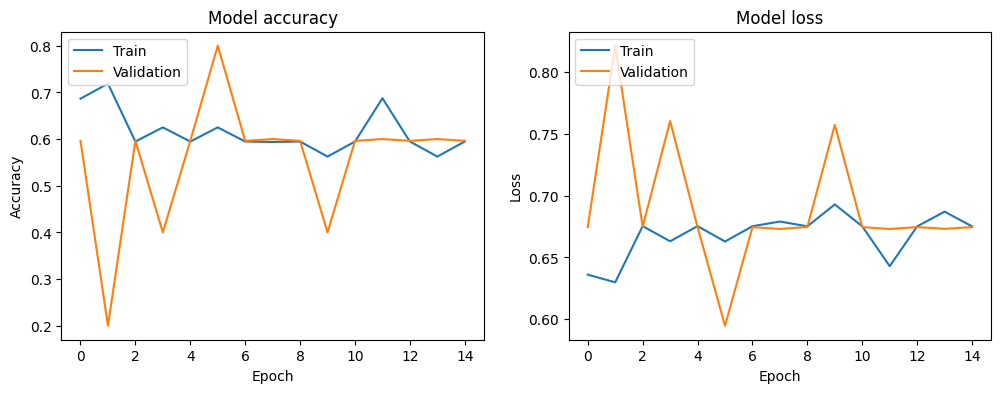

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Initial results

This model was very slow to train, even with only 15 epochs, using a fairly powerful GPU, and it has no shown signs of convergence.  Perhaps we'll have better lock with a different optimizer

In [29]:
# Configuration
pre_trained_weights = 'imagenet'
height = 96
width = 96
channels = 3

model_basic = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_basic.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_basic.summary()

/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
#Train the model

# Commenting out to prevent re-running
# epochs = 25

# labels_tif_df = pd.read_csv('data/train_labels.csv')
# labels_tif_df['id'] = labels_tif_df['id'].apply(lambda x: f"{x}.tif")  # Append .tif for filename
# labels_tif_df['label'] = labels_tif_df['label'].astype(str)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split=0.2
# )

# train_generator = train_datagen.flow_from_dataframe(
#     dataframe=labels_tif_df,
#     directory='data/train',
#     x_col='id',
#     y_col='label',
#     target_size=(height, width),
#     batch_size=128, # Increase batch size from 32
#     class_mode='binary',
#     subset='training'  # Set as training data
# )

# validation_generator = train_datagen.flow_from_dataframe(
#     dataframe=labels_tif_df,
#     directory='data/train',
#     x_col='id',
#     y_col='label',
#     target_size=(height, width),
#     batch_size=128, # Increase batch size from 32
#     class_mode='binary',
#     subset='validation'  # Set as validation data
# )

# history = model_basic.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size
# )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Epoch 1/25


/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 281s 203ms/step - accuracy: 0.7381 - loss: 0.5371 - val_accuracy: 0.8051 - val_loss: 0.4366
Epoch 2/25
   1/1375 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - accuracy: 0.8047 - loss: 0.4466

2024-06-30 13:32:34.013667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/mark/.pyenv/versions/3.10.13/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-30 13:32:34.013685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2746171282040841050
2024-06-30 13:32:34.013690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12791377873449075800
2024-06-30 13:32:34.013694: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3100088300080187250
2024-06-30 13:32:34.01

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 0.8047 - loss: 0.4466 - val_accuracy: 0.7921 - val_loss: 0.4311
Epoch 3/25


2024-06-30 13:32:34.235178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 13:32:34.235195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-30 13:32:34.235201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15137716473183496279
2024-06-30 13:32:34.235205: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4015869805236643817
2024-06-30 13:32:34.235212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8676880970492657740


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 276s 200ms/step - accuracy: 0.8073 - loss: 0.4328 - val_accuracy: 0.8078 - val_loss: 0.4320
Epoch 4/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 90us/step - accuracy: 0.8281 - loss: 0.4553 - val_accuracy: 0.8317 - val_loss: 0.3624
Epoch 5/25


2024-06-30 13:37:10.547072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 13:37:10.547092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2746171282040841050
2024-06-30 13:37:10.547100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_12/_46]]
2024-06-30 13:37:10.547117: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12791377873449075800
2024-06-30 13:37:10.547130: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8661561940302565311
2024-06-30 13:37:10.547142: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 573014148

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 284s 205ms/step - accuracy: 0.8187 - loss: 0.4122 - val_accuracy: 0.8153 - val_loss: 0.4167
Epoch 6/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8359 - loss: 0.3987 - val_accuracy: 0.8119 - val_loss: 0.4173
Epoch 7/25


2024-06-30 13:41:54.422402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 13:41:54.422416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_2_1/dropout_8_1/ReadVariableOp_1/_19]]
2024-06-30 13:41:54.422424: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2746171282040841050
2024-06-30 13:41:54.422426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 13:41:54.422429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12791377873449075800
2024-06-30 13:41:54.422435: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv ite

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 282s 204ms/step - accuracy: 0.8271 - loss: 0.3980 - val_accuracy: 0.8117 - val_loss: 0.4234
Epoch 8/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.8281 - loss: 0.3966 - val_accuracy: 0.8713 - val_loss: 0.3282
Epoch 9/25


2024-06-30 13:46:36.768416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 13:46:36.768434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_42]]
2024-06-30 13:46:36.768447: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5384589063349776226
2024-06-30 13:46:36.768457: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 13:46:36.768463: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15762953731025236558
2024-06-30 13:46:36.768467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1153986828

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 274s 198ms/step - accuracy: 0.8303 - loss: 0.3899 - val_accuracy: 0.8442 - val_loss: 0.3623
Epoch 10/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 91us/step - accuracy: 0.8594 - loss: 0.3655 - val_accuracy: 0.8218 - val_loss: 0.3969
Epoch 11/25


2024-06-30 13:51:10.531587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 13:51:10.531603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_48]]
2024-06-30 13:51:10.531611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 13:51:10.531616: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10454144613197246361
2024-06-30 13:51:10.531621: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11539868282164839407
2024-06-30 13:51:10.531626: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14695420

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 283s 205ms/step - accuracy: 0.8353 - loss: 0.3798 - val_accuracy: 0.8394 - val_loss: 0.3657
Epoch 12/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.8281 - loss: 0.3910 - val_accuracy: 0.8218 - val_loss: 0.4022
Epoch 13/25


2024-06-30 13:55:54.079119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 13:55:54.079138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/binary_crossentropy/mod/_61]]
2024-06-30 13:55:54.079155: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5384589063349776226
2024-06-30 13:55:54.079169: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15762953731025236558
2024-06-30 13:55:54.079172: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 13:55:54.079188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous r

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 337s 244ms/step - accuracy: 0.8372 - loss: 0.3775 - val_accuracy: 0.8450 - val_loss: 0.3559
Epoch 14/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.8203 - loss: 0.3954 - val_accuracy: 0.8119 - val_loss: 0.4039
Epoch 15/25


2024-06-30 14:01:31.417321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:01:31.417335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_42]]
2024-06-30 14:01:31.417345: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 14:01:31.417349: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5384589063349776226
2024-06-30 14:01:31.417356: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11539868282164839407
2024-06-30 14:01:31.417359: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1576295373

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 493s 358ms/step - accuracy: 0.8407 - loss: 0.3697 - val_accuracy: 0.8461 - val_loss: 0.3543
Epoch 16/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.8750 - loss: 0.3261 - val_accuracy: 0.8317 - val_loss: 0.3286
Epoch 17/25


2024-06-30 14:09:44.245770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:09:44.245788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_4/_38]]
2024-06-30 14:09:44.245802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5384589063349776226
2024-06-30 14:09:44.245808: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2746171282040841050
2024-06-30 14:09:44.245812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15762953731025236558
2024-06-30 14:09:44.245819: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 337s 244ms/step - accuracy: 0.8416 - loss: 0.3655 - val_accuracy: 0.8516 - val_loss: 0.3464
Epoch 18/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.8281 - loss: 0.3575 - val_accuracy: 0.8416 - val_loss: 0.3305
Epoch 19/25


2024-06-30 14:15:21.366711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:15:21.366725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_26]]
2024-06-30 14:15:21.366732: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 14:15:21.366738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11539868282164839407
2024-06-30 14:15:21.366742: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4335760909002294317
2024-06-30 14:15:21.366748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1969141812735993693
2024-06-3

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 276s 200ms/step - accuracy: 0.8435 - loss: 0.3623 - val_accuracy: 0.8515 - val_loss: 0.3422
Epoch 20/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.8203 - loss: 0.3993 - val_accuracy: 0.8218 - val_loss: 0.4287
Epoch 21/25


2024-06-30 14:19:57.224154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:19:57.224184: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2746171282040841050
2024-06-30 14:19:57.224192: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12791377873449075800
2024-06-30 14:19:57.224201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3100088300080187250
2024-06-30 14:19:57.224208: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12508860949591205864
2024-06-30 14:19:57.224211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequen

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 443s 321ms/step - accuracy: 0.8451 - loss: 0.3605 - val_accuracy: 0.8479 - val_loss: 0.3480
Epoch 22/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.8906 - loss: 0.3095 - val_accuracy: 0.8317 - val_loss: 0.3695
Epoch 23/25


2024-06-30 14:27:20.273631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:27:20.273650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_44]]
2024-06-30 14:27:20.273662: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 14:27:20.273667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11539868282164839407
2024-06-30 14:27:20.273674: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4335760909002294317
2024-06-30 14:27:20.273678: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 146954206

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 384s 278ms/step - accuracy: 0.8463 - loss: 0.3564 - val_accuracy: 0.8549 - val_loss: 0.3348
Epoch 24/25
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.8828 - loss: 0.3130 - val_accuracy: 0.8713 - val_loss: 0.2796
Epoch 25/25


2024-06-30 14:33:44.413508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-30 14:33:44.413526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_26]]
2024-06-30 14:33:44.413534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3100088300080187250
2024-06-30 14:33:44.413540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7113666955365957679
2024-06-30 14:33:44.413545: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11539868282164839407
2024-06-30 14:33:44.413548: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14695420657453233195
2024-06-

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 275s 199ms/step - accuracy: 0.8493 - loss: 0.3506 - val_accuracy: 0.8604 - val_loss: 0.3264


In [31]:
model_basic.save('model_basic.keras')

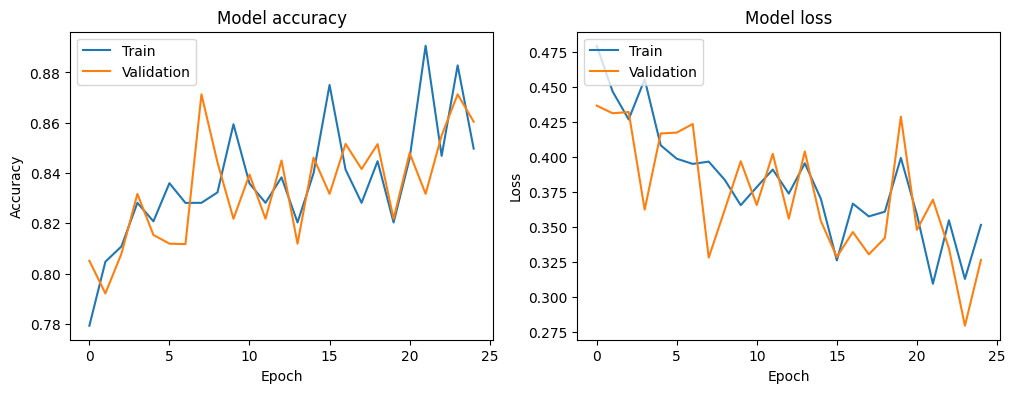

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [44]:
# Creating predictions for submitting to kaggle

test_labels_df = pd.DataFrame({'id': os.listdir('data/test')})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_df,
    directory='data/test',
    x_col='id',
    target_size=(height, width),
    batch_size=64,
    class_mode=None,  # No labels for test data
    shuffle=False
)

predictions = model_basic.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

binary_predictions = (predictions >= 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'id': test_generator.filenames,
    'label': binary_predictions.flatten()  # Ensure predictions are in the correct shape
})

submission_df['id'] = submission_df['id'].str.replace('.tif', '')

submission_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step


## Step 4: Results and Analysis

Above you'll find that two different models were attempted, a VGG architecture, and much simpler, basic sequential model.  The VGG model was very slow to train, so in the interest of time, we adjusted a few hyperparameters:

- Batch size
- Number of epochs
- Number of layers
- Momentum
- Optimizer
- Etc

It appears that the model needs many more epochs to converge.  I submitted to Kaggle with the current results, and achieved a score of 0.6788.  

# Step 5: Conclusion

It's clear that a much longer training time is needed for the model to converge.  I'm going to try running the model trainer over the course of an entire day to see if I can get better results.  Some hyperparameters were able to reduce the run time considerably, but even with a very powerful GPU, it's clear that model architecture is important to have reasonable training times.

Still we were able to achieve better-than-random chance accuracy on the validation set, which is reassurring that I'm on the right track.